<a href="https://colab.research.google.com/github/peterbmob/DHMVADoE/blob/main/AdvancedRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariable regression Tutorial
In this last excercise, we will take data handling and model creation one step further and look in to machine learning techniques. The content is adapted from the paper [Machine Learning for Materials Scientists: An Introductory Guide toward Best Practices](https://pubs.acs.org/doi/full/10.1021/acs.chemmater.0c01907).

# 1. Data loading, cleanup and processing
adapted from
The first step to a ML project is to obtain the dataset you will be working with. There are many repositories for materials science-specific data (whether online or offline)---consult the accompanying paper for a list of the more commonly used ones.

Once you have identified the repository and dataset you will use for your project, you will have to download it to your local machine, or establish a way to reliably access the dataset. Consult the documentation of the repository for how to do this.

For this tutorial, we have collected heat capacity (
) data from the [NIST-JANAF Thermochemical Tables](https://doi.org/10.18434/T42S31).

In [1]:
# install missing pacjkages
!pip install -U ydata-profiling[notebook]==4.0.0 # matplotlib==3.5.1

In [2]:
# load necessarry libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from ydata_profiling import ProfileReport

## Load data
Using Pandas, we read in the dataset into a DataFrame.

We also print the shape of the DataFrame, which indicates the number of rows and columns in this dataset.

In [3]:
url = r'https://raw.githubusercontent.com/peterbmob/DHMVADoE/main/DATA/cp_data_demo.csv'
df = pd.read_csv(url)
print(f'Original DataFrame shape: {df.shape}')

Original DataFrame shape: (4583, 3)


## Examine the data
We examine some rows and look at the data's basic statistics.

We see that the dataset contains information about the formula, measurement condition (in this case, temperature in K), and the target property, heat capacity (in J/(mol * K)).

In [4]:
df.head(10)

,FORMULA,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
0,B2O3,1400.0,134.306
1,B2O3,1300.0,131.294
2,B2O3,1200.0,128.072
3,B2O3,1100.0,124.516
4,B2O3,1000.0,120.625
5,B2O3,900.0,116.190
6,B2O3,800.0,111.169
7,B2O3,723.0,106.692
8,B2O3,700.0,105.228
9,B2O3,600.0,98.115


First thing you should notice: we have many observations of the same compound (B2O3) but measured at different measurement conditions, resulting in a different property value.

We can get some simple summary statistics of the DataFrame by calling the .describe() method on the database.

In [5]:
df.describe()

,CONDITION: Temperature (K),PROPERTY: Heat Capacity (J/mol K)
count,4579.000000,4576.000000
mean,1170.920341,107.483627
std,741.254366,67.019055
min,-2000.000000,-102.215000
25%,600.000000,61.312500
50%,1000.000000,89.497000
75%,1600.000000,135.645000
max,4700.000000,494.967000


Using the pandas-profiling library, we can generate a more in-depth report of our starting dataset. Note that generating this profile report might take upwards of 20 seconds.

In [9]:
profile = ProfileReport(df.copy(), title='Pandas Profiling Report of Cp dataset', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Notice a few things from the profile report:

- We have some missing cells in the dataset ("Overview" tab)
- We have some unrealistic Temperature and Heat Capacity values in the dataset ("Variables" tab)
- We have some missing Temperature, Formula and Heat Capacity values in the dataset ("Variables" tab)

Also notice that on the "Overview" tab, there is the following warning: FORMULA has a high cardinality: 245 distinct values.
Cardinality is the number of distinct values in a column of a table, relative to the number of rows in the table.

In our dataset, we have a total of 4583 data observations, but only 245 distinct formulae. We will have to keep this in mind later, when we process and split the dataset.

## Rename the column names for brevity

In [10]:

df.columns

Index(['FORMULA', 'CONDITION: Temperature (K)',
       'PROPERTY: Heat Capacity (J/mol K)'],
      dtype='object')

In [11]:
rename_dict = {'FORMULA': 'formula',
               'CONDITION: Temperature (K)': 'T',
               'PROPERTY: Heat Capacity (J/mol K)': 'Cp'}
df = df.rename(columns=rename_dict)
df.columns

Index(['formula', 'T', 'Cp'], dtype='object')

## Check for and remove NaN values

In [12]:
# Check for NaNs in the respective dataset columns, and get the indices
df2 = df.copy()
bool_nans_formula = df2['formula'].isnull()
bool_nans_T = df2['T'].isnull()
bool_nans_Cp = df2['Cp'].isnull()

# Drop the rows of the DataFrame which contain NaNs
df2 = df2.drop(df2.loc[bool_nans_formula].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_T].index, axis=0)
df2 = df2.drop(df2.loc[bool_nans_Cp].index, axis=0)

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df2.shape}')

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


Pandas also includes the convenient built-in method .dropna() to check for and remove NaNs in-place:



In [13]:
df3 = df.copy()
df3 = df3.dropna(axis=0, how='any')

print(f'DataFrame shape before dropping NaNs: {df.shape}')
print(f'DataFrame shape after dropping NaNs: {df3.shape}')

df = df3.copy()

DataFrame shape before dropping NaNs: (4583, 3)
DataFrame shape after dropping NaNs: (4570, 3)


## Check for and remove unrealistic values
In some cases, you might also get data values that simply don't make sense. For our dase, this could be negative values in the temperature or heat capacity values.

In [14]:
bool_invalid_T = df['T'] < 0
bool_invalid_Cp = df['Cp'] < 0

df = df.drop(df.loc[bool_invalid_T].index, axis=0)
df = df.drop(df.loc[bool_invalid_Cp].index, axis=0)

print(f'Cleaned DataFrame shape: {df.shape}')

Cleaned DataFrame shape: (4564, 3)


## Save cleaned data to csv
Finally, after cleaning and processing the data, you can save it to disk in a cleaned state for you to use later.

Pandas allows us to save our data as a comma separated value .csv file.

In [16]:
out_path = os.path.join('cp_data_cleaned.csv')
df.to_csv(out_path, index=False)

In [17]:
!ls

cp_data_cleaned.csv  sample_data


# 2. Data Splitting
Splitting data into the train/validation/test dataset
It is important to split your full dataset into train/validation/test datasets, and reliably use the same datasets for your modeling tasks later.

Using different train/validation/test splits can dramatically affect your model performance (as seen here by the variance in
 scores for 30 models which have been trained on 30 different dataset splits) [1]:

In [18]:
# import necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.model_selection import train_test_split

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(seed=RNG_SEED)

## Load the pre-processed dataset

We will start with the processed dataset that we saved previously.

In [19]:
PATH = os.getcwd()
data_path = os.path.join(PATH, 'cp_data_cleaned.csv')

df = pd.read_csv(data_path)
print(f'Full DataFrame shape: {df.shape}')

Full DataFrame shape: (4564, 3)


## Separate the DataFrame into your input variables (X) and target variables (y)
The X will be used as the input data, and y will be used as the prediction targets for your ML model.

If your target variables are discrete (such as metal/non-metal or types of crystal structures), then you will be performing a classification task. In our case, since our target variables are continuous values (heat capacity), we are performing a regression task.

In [20]:
X = df[['formula', 'T']]
y = df['Cp']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (4564, 2)
Shape of y: (4564,)


## Splitting data (and a word of caution)
Normally, we could simply split the data with a simple sklearn function
The scikit-learn train_test_split function randomly splits a dataset into train and test datasets. Typically, you can use train_test_split to first split your data into "train" and "test" datasets, and then use the function again to split your "train" data into "train" and "validation" dataset splits.

As a rule of thumb, you can roughly aim for the following dataset proportions when splitting your data:

| | train split | validation split | test split |
| --- | --- | --- | --- |
| proportion of original dataset | 50% to 70% | 20% to 30% | 10% to20% |


If you have copious amounts of data, it may suffice to train your models on just 50% of the data; that way, you have a larger amount of data samples to validate and to test with. If you however have a smaller dataset and thus very few training samples for your models, you may wish to increase your proportion of training data during dataset splitting.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RNG_SEED)

print(X_train.shape)
print(X_test.shape)

(3651, 2)
(913, 2)


**But wait, what's wrong here?**
We have to make sure that our dataset splits contain mutually exclusive formulae (e.g., all the data samples associated with "Al2O3" is either in the train, validation, or test dataset, but not in multiple)!

In [22]:
num_rows = len(X_train)
print(f'There are in total {num_rows} rows in the X_train DataFrame.')

num_unique_formulae = len(X_train['formula'].unique())
print(f'But there are only {num_unique_formulae} unique formulae!\n')

print('Unique formulae and their number of occurances in the X_train DataFrame:')
print(X_train['formula'].value_counts(), '\n')
print('Unique formulae and their number of occurances in the X_test DataFrame:')
print(X_test['formula'].value_counts())

There are in total 3651 rows in the X_train DataFrame.
But there are only 244 unique formulae!

Unique formulae and their number of occurances in the X_train DataFrame:
W1         40
N1Ti1      38
N1Zr1      33
B1Ti1      33
O2Zr1      30
           ..
Be1H2O2     4
N2O4        3
K1          2
Hg1O1       1
I4Ti1       1
Name: formula, Length: 244, dtype: int64 

Unique formulae and their number of occurances in the X_test DataFrame:
Ca1S1       10
Be2O4Si1    10
N0.465V1    10
W1           9
O3W1         9
            ..
C1Cu1N1      1
I4Zr1        1
Ca1          1
O1Pb1        1
I1K1         1
Name: formula, Length: 229, dtype: int64


There are in total 3651 rows in the X_train DataFrame. But there are only 244 unique formulae! In fact, you will see that the same formulae are often present in the X_train and X_test DataFrames!

That's not good, because now we have instances of the same chemical compound appearing in both the training and test data. Which means the model can cheat and in essence just memorize the training data, and during testing, look up the nearby values present in the training data!

So how do we mitigate this?

**Be aware of leaking data between datasets**
We have to first group the data by chemical formula, then split the data according to the chemical formulae. That way, all data points associated with each formula are either in the training dataset or in the test dataset, but not in both at the same time.

## Splitting data, cautiously (manually)
First we get a list of all of the unique formulae in the dataset.

In [23]:
unique_formulae = X['formula'].unique()
print(f'{len(unique_formulae)} unique formulae:\n{unique_formulae}')

244 unique formulae:
['B2O3' 'Be1I2' 'Be1F3Li1' 'Al1Cl4K1' 'Al2Be1O4' 'B2H4O4' 'B2Mg1' 'Be1F2'
 'B1H4Na1' 'Br2Ca1' 'Al1N1' 'Al1Cl6Na3' 'Ba1H2O2' 'Al1Br3' 'Br3Zr1'
 'Br2Ti1' 'B1Ti1' 'Be2O4Si1' 'Br2Pb1' 'Al1' 'Br2Hg2' 'B1H3O3' 'Br3Ti1'
 'C1Cu1N1' 'B1' 'Al1F6Na3' 'Ca1H2O2' 'B2Be3O6' 'Al1Cl4Na1' 'Al1Cl6K3'
 'C0.98Nb1' 'Br2Hg1' 'Al1Cl1O1' 'Cl1H4N1O4' 'Be1F4Li2' 'C1Mg1O3' 'Br1H4N1'
 'Ca1I2' 'Al1F6Li3' 'Br4Mo1' 'Ba1' 'Br4Ti1' 'Ba1Br2' 'Be1O4S1' 'Ba1F2'
 'Ba1I2' 'Cl2Fe1' 'C1K1N1' 'Be1H2O2' 'Cs1' 'Al1H4Li1' 'C1Be2' 'Cr1'
 'Cs2O4S1' 'Cl1Cu1' 'Cu1F2' 'Al2O3' 'B1N1' 'Co1O4S1' 'Cu1O1' 'Br1Na1'
 'Cr2O3' 'Cs1F1' 'Cr2N1' 'Cl1Li1' 'Fe0.877S1' 'Cl1Na1' 'F2Hg1' 'Fe1H2O2'
 'Cs1H1O1' 'Br3Mo1' 'Br2Sr1' 'Cl2Hg2' 'Fe1O1' 'Co1' 'Cl1Cs1' 'Cu1H2O2'
 'Al1Li1O2' 'Co1F2' 'Br2Fe1' 'Fe1I2' 'Ga1' 'Cl1Li1O4' 'Cl2Cu1' 'Fe0.947O1'
 'Be1Cl2' 'Cl1K1' 'F1Na1' 'H3O4P1' 'Fe3O4' 'H1Na1O1' 'Fe2O12S3' 'H1Na1'
 'Cl1Na1O4' 'B1F4K1' 'Cu1O4S1' 'H1Li1' 'F2H1K1' 'B1H4Li1' 'Hg1O1' 'Be3N2'
 'Fe1' 'I2Mo1' 'Cu1F1' 'Cr1N1' 'Fe1H3O3' 'I1Li1

In [24]:
# Set a random seed to ensure reproducibility across runs
np.random.seed(seed=RNG_SEED)

# Store a list of all unique formulae
all_formulae = unique_formulae.copy()

# Define the proportional size of the dataset split
val_size = 0.20
test_size = 0.10
train_size = 1 - val_size - test_size

# Calculate the number of samples in each dataset split
num_val_samples = int(round(val_size * len(unique_formulae)))
num_test_samples = int(round(test_size * len(unique_formulae)))
num_train_samples = int(round((1 - val_size - test_size) * len(unique_formulae)))

# Randomly choose the formulate for the validation dataset, and remove those from the unique formulae list
val_formulae = np.random.choice(all_formulae, size=num_val_samples, replace=False)
all_formulae = [f for f in all_formulae if f not in val_formulae]

# Randomly choose the formulate for the test dataset, and remove those from the unique formulae list
test_formulae = np.random.choice(all_formulae, size=num_test_samples, replace=False)
all_formulae = [f for f in all_formulae if f not in test_formulae]

# The remaining formulae will be used for the training dataset
train_formulae = all_formulae.copy()

print('Number of training formulae:', len(train_formulae))
print('Number of validation formulae:', len(val_formulae))
print('Number of testing formulae:', len(test_formulae))

Number of training formulae: 171
Number of validation formulae: 49
Number of testing formulae: 24


In [25]:
# Split the original dataset into the train/validation/test datasets using the formulae lists above
df_train = df[df['formula'].isin(train_formulae)]
df_val = df[df['formula'].isin(val_formulae)]
df_test = df[df['formula'].isin(test_formulae)]

print(f'train dataset shape: {df_train.shape}')
print(f'validation dataset shape: {df_val.shape}')
print(f'test dataset shape: {df_test.shape}\n')

print(df_train.head(), '\n')
print(df_val.head(), '\n')
print(df_test.head(), '\n')

train dataset shape: (3214, 3)
validation dataset shape: (980, 3)
test dataset shape: (370, 3)

  formula       T       Cp
0    B2O3  1400.0  134.306
1    B2O3  1300.0  131.294
2    B2O3  1200.0  128.072
3    B2O3  1100.0  124.516
4    B2O3  1000.0  120.625 

   formula       T      Cp
82   B2Mg1  1900.0  92.242
83   B2Mg1  1800.0  90.249
84   B2Mg1  1700.0  88.162
85   B2Mg1  1600.0  85.981
86   B2Mg1  1500.0  83.643 

     formula       T       Cp
192  Ba1H2O2  900.00  134.892
193  Ba1H2O2  800.00  130.834
194  Ba1H2O2  700.00  126.775
195  Ba1H2O2  681.15  126.022
196  Ba1H2O2  600.00  122.717 



To be sure that we really only have mutually exclusive formulae within each of the datasets (e.g., all the data samples associated with "Al2O3" is either in the train, validation, or test dataset, but not in multiple), we can do the following to check:

In [27]:
train_formulae = set(df_train['formula'].unique())
val_formulae = set(df_val['formula'].unique())
test_formulae = set(df_test['formula'].unique())

common_formulae1 = train_formulae.intersection(test_formulae)
common_formulae2 = train_formulae.intersection(val_formulae)
common_formulae3 = test_formulae.intersection(val_formulae)

print(f'# of common formulae in intersection 1: {len(common_formulae1)}; common formulae: {common_formulae1}')
print(f'# of common formulae in intersection 2: {len(common_formulae2)}; common formulae: {common_formulae2}')
print(f'# of common formulae in intersection 3: {len(common_formulae3)}; common formulae: {common_formulae3}')

# of common formulae in intersection 1: 0; common formulae: set()
# of common formulae in intersection 2: 0; common formulae: set()
# of common formulae in intersection 3: 0; common formulae: set()


## Save split datasets to csv
Finally, after splitting the dataset into train/validation/test dataset splits, you can save them to disk for you to use later.

By saving these dataset splits into files, you can then later reproducibly use these same exact splits during your subsequent model training and comparison steps. Use the same datasets for all your models---that way, you can ensure a fair comparison.

Also, when you publish your results, you can include these dataset splits, so that others can use the exact datasets in their own studies.

In [28]:
# saving these splits into csv files
PATH = os.getcwd()

train_path = os.path.join(PATH, 'cp_train.csv')
val_path = os.path.join(PATH, 'cp_val.csv')
test_path = os.path.join(PATH, 'cp_test.csv')

df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Remember, keep the test dataset locked away and forget about it until you have finalized your model! **Never look at the test dataset!!**

# 3. Data Featurization
Here, we will show some simple examples of featurizing materials composition data using so-called "composition-based feature vectors", or CBFVs. This methods represents a single chemical formula as one vector based on its constituent atoms' chemical properties (refer to the paper for more information and references).

Note that the steps shown in this notebook are intended to demonstrate the best practices associated with featurizing materials data, using one way of featurizing materials composition data as an example. Depending on your input data and your particular modeling needs, the data featurization method and procedure you use may be different than the example shown here.

In [29]:
# As usual, first load necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict

# Set a random seed to ensure reproducibility across runs
RNG_SEED = 42
np.random.seed(RNG_SEED)

## Load the data

In [30]:
PATH = os.getcwd()
train_path = os.path.join(PATH, 'cp_train.csv')
val_path = os.path.join(PATH, 'cp_val.csv')
test_path = os.path.join(PATH, 'cp_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f'df_train DataFrame shape: {df_train.shape}')
print(f'df_val DataFrame shape: {df_val.shape}')
print(f'df_test DataFrame shape: {df_test.shape}')

df_train DataFrame shape: (3214, 3)
df_val DataFrame shape: (980, 3)
df_test DataFrame shape: (370, 3)


## Sub-sampling your data (optional)
If your dataset is too large, you can subsample it to be a smaller size. This is useful for prototyping and for making quick sanity tests of new models / parameters.

Just be aware that you do not introduce any bias into your data through the sampling.

In [32]:
# Sub-sample the data. Set the random_state to make the sampling reproducible every time.
df_train_sampled = df_train.sample(n=2000, random_state=RNG_SEED)
df_val_sampled = df_val.sample(n=200, random_state=RNG_SEED)
df_test_sampled = df_test.sample(n=200, random_state=RNG_SEED)

print(f'df_train_sampled DataFrame shape: {df_train_sampled.shape}')
print(f'df_val_sampled DataFrame shape: {df_val_sampled.shape}')
print(f'df_test_sampled DataFrame shape: {df_test_sampled.shape}')

df_train_sampled DataFrame shape: (2000, 3)
df_val_sampled DataFrame shape: (200, 3)
df_test_sampled DataFrame shape: (200, 3)


## Generate features using the CBFV package
To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [CBFV package](https://github.com/kaaiian/CBFV).

To use it, we need to download the package. This we can do by cloning the git repository to our colab environment.


In [33]:
! git clone https://github.com/Kaaiian/CBFV.git

Cloning into 'CBFV'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 235 (delta 35), reused 37 (delta 27), pack-reused 184
Receiving objects: 100% (235/235), 5.12 MiB | 9.51 MiB/s, done.
Resolving deltas: 100% (102/102), done.


now we can import the module

In [34]:
# Import the package and the generate_features function
from CBFV.cbfv.composition import generate_features

The generate_features function from the CBFV package expects an input DataFrame containing at least the columns ['formula', 'target']. You may also have extra feature columns (e.g., temperature or pressure, other measurement conditions, etc.).

In our dataset, Cp represents the target variable, and T is the measurement condition. Since the generate_features function expects the target variable column to be named target, we have to rename the Cp column.

In [35]:
print('DataFrame column names before renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

rename_dict = {'Cp': 'target'}
df_train = df_train.rename(columns=rename_dict)
df_val = df_val.rename(columns=rename_dict)
df_test = df_test.rename(columns=rename_dict)

df_train_sampled = df_train_sampled.rename(columns=rename_dict)
df_val_sampled = df_val_sampled.rename(columns=rename_dict)
df_test_sampled = df_test_sampled.rename(columns=rename_dict)

print('\nDataFrame column names after renaming:')
print(df_train.columns)
print(df_val.columns)
print(df_test.columns)

DataFrame column names before renaming:
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')
Index(['formula', 'T', 'Cp'], dtype='object')

DataFrame column names after renaming:
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')
Index(['formula', 'T', 'target'], dtype='object')


Now we can use the generate_features function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to generate_features:

- elem_prop='oliynyk'
- drop_duplicates=False
- extend_features=True
- sum_feat=True

A short explanation for the choice of keyword arguments is below:

- The elem_prop parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the oliynyk CBFV featurization scheme.
- The drop_duplicates parameter specifies whether to drop duplicate formulae during featurization. In our case, we want to preserve duplicate formulae in our data (True), since we have multiple heat capacity measurements (performed at different temperatures) for the same compound.
- The extend_features parameter specifies whether to include extended features (features that are not part of ['formula', 'target']) in the featurized data. In our case, this is our measurement temperature, and we want to include this information (True), since this is pertinent information for the heat capacity prediction.
- The sum_feat parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (True).

For more information about the generate_features function and the CBFV featurization scheme, refer to the [GitHub repository](https://github.com/kaaiian/CBFV).

In [37]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df_train_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_val_unscaled, y_val, formulae_val, skipped_val = generate_features(df_val_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)
X_test_unscaled, y_test, formulae_test, skipped_test = generate_features(df_test_sampled, elem_prop='oliynyk', drop_duplicates=False, extend_features=True, sum_feat=True)

Processing Input Data: 100%|██████████| 2000/2000 [00:00<00:00, 15684.68it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2000/2000 [00:00<00:00, 8189.78it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 200/200 [00:00<00:00, 3675.02it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 200/200 [00:00<00:00, 1639.56it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 200/200 [00:00<00:00, 4258.72it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 200/200 [00:00<00:00, 1501.85it/s]


	Creating Pandas Objects...


To see what a featurized X matrix looks like, .head() will show us some rows:

In [38]:
X_train_unscaled.head()

,sum_Atomic_Number,sum_Atomic_Weight,sum_Period,sum_group,sum_families,sum_Metal,sum_Nonmetal,sum_Metalliod,sum_Mendeleev_Number,sum_l_quantum_number,...,mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy,T
0,32.0,65.116040,8.0,30.0,15.0,1.0,2.0,0.0,162.0,2.0,...,63.25,77.35,0.00125,0.710,0.3604,2.79280,0.02598,90.0,0.934,600.0
1,28.0,53.491200,9.0,36.0,43.0,0.0,6.0,0.0,544.0,2.0,...,14.05,20.25,0.00007,14.304,0.5868,0.44936,0.18150,218.0,0.000,457.7
2,46.0,98.887792,14.0,72.0,36.0,3.0,4.0,0.0,441.0,4.0,...,53.35,85.05,0.00170,0.820,0.2552,3.26980,0.02790,79.0,0.840,300.0
3,20.0,41.988171,5.0,18.0,9.0,1.0,1.0,0.0,95.0,1.0,...,53.35,85.05,0.00170,0.820,0.2552,3.26980,0.02790,79.0,0.840,2800.0
4,82.0,207.200000,6.0,14.0,5.0,1.0,0.0,0.0,81.0,1.0,...,600.65,2013.15,11.40000,0.130,4.7990,177.70000,35.30000,196.0,2.030,1400.0


In [39]:
X_train_unscaled.shape

(2000, 309)

Note the sum features in the CBFV, which we have included by using sum_feat=True in the call to generate_features.

Also note the temperature column T at the end of this featurized data.

What we have done above is featurize the input data. In the featurized data, each row contains a unique CBFV that describes a given chemical composition.

# 4. Data scaling & normalization
For numerical input data, scaling and normalization of the features often improves the model performance. Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others). This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn. Consult the documentation for the details and when to use them.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

## Scaling the data
First, we instantiate the scaler object.

In a `StandardScaler` object:

- During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
- Then, during the `transform process`, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data. For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should only `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

## Normalizing the scaled data
We repeat a similar process for normalizing the data. Here, there is no need to first fit the normalizer, since the normalizer scales the rows of the input data to unit norm independently of other rows.

The normalizer is different to a Scaler in that the normalizer acts row-wise, whereas a Scaler acts column-wise on the input data.

In [42]:
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

5. Making the model
Here we will use the multiple multivariate regression from sklearn.

In [47]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)


LinearRegression()

In [61]:
y_train_pred = regr.predict(X_train)

Root mean squared error = 14.8527
R-squared = 0.9399


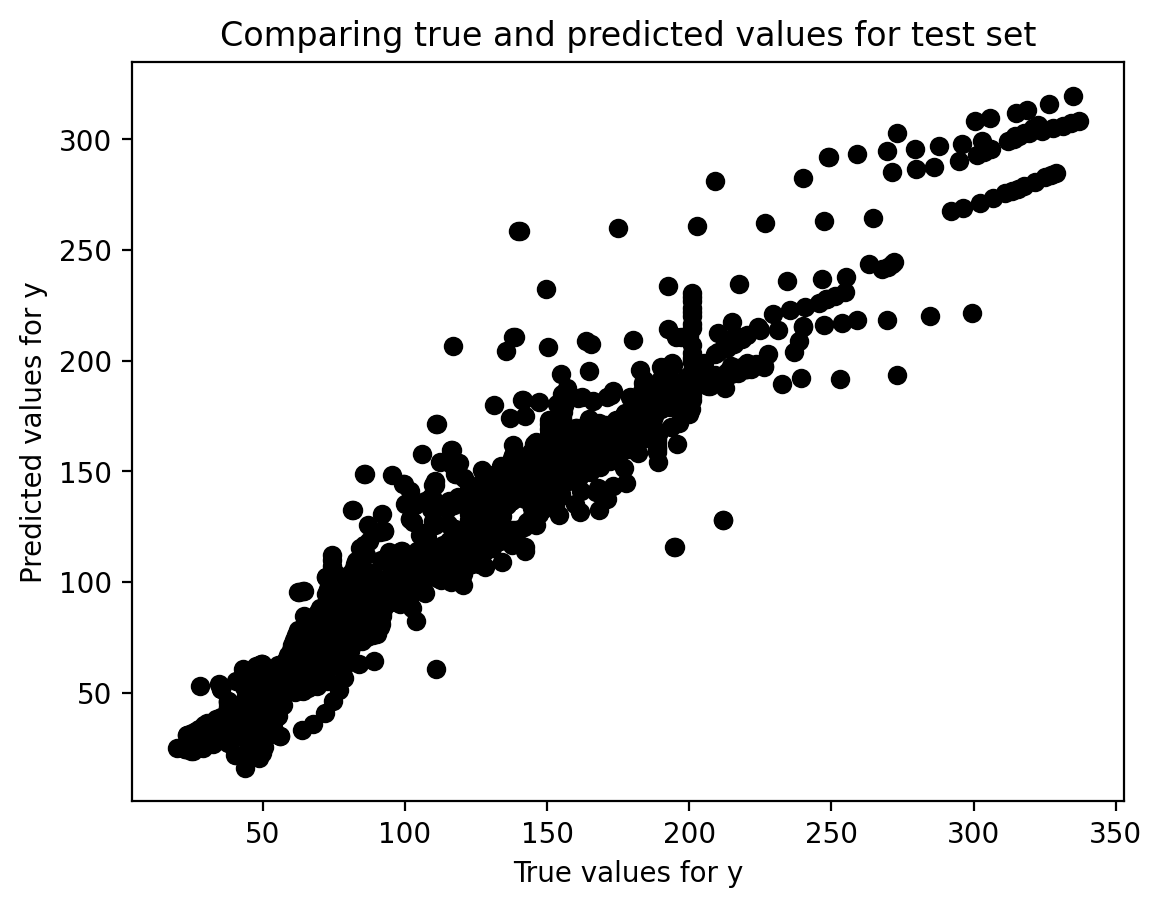

In [62]:
# Comparing true versus predicted values
plt.scatter(y_train, y_train_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('R-squared = %.4f' % r2_score(y_train, y_train_pred))

But the question is how good we are on the test set...

In [63]:
y_val_pred = regr.predict(X_val)

Root mean squared error = 6469635268418.3486
R-squared = -8081302961227767480320.0000


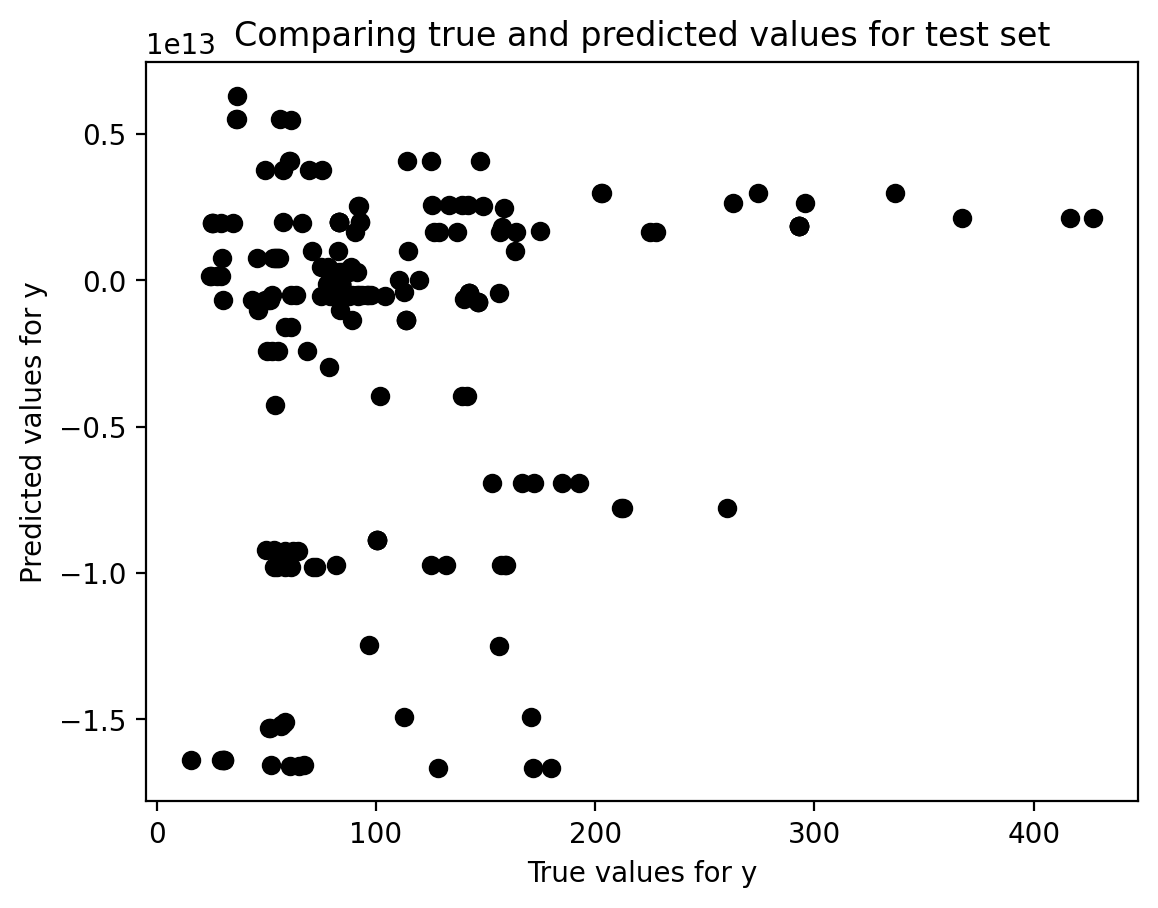

In [64]:
# Comparing true versus predicted values
plt.scatter(y_val, y_val_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('R-squared = %.4f' % r2_score(y_val, y_val_pred))

Ock så hade vi ju vårt test set...

In [65]:
y_test_pred = regr.predict(X_test)

Root mean squared error = 8534295666456.7354
R-squared = -14062326026960048750592.0000


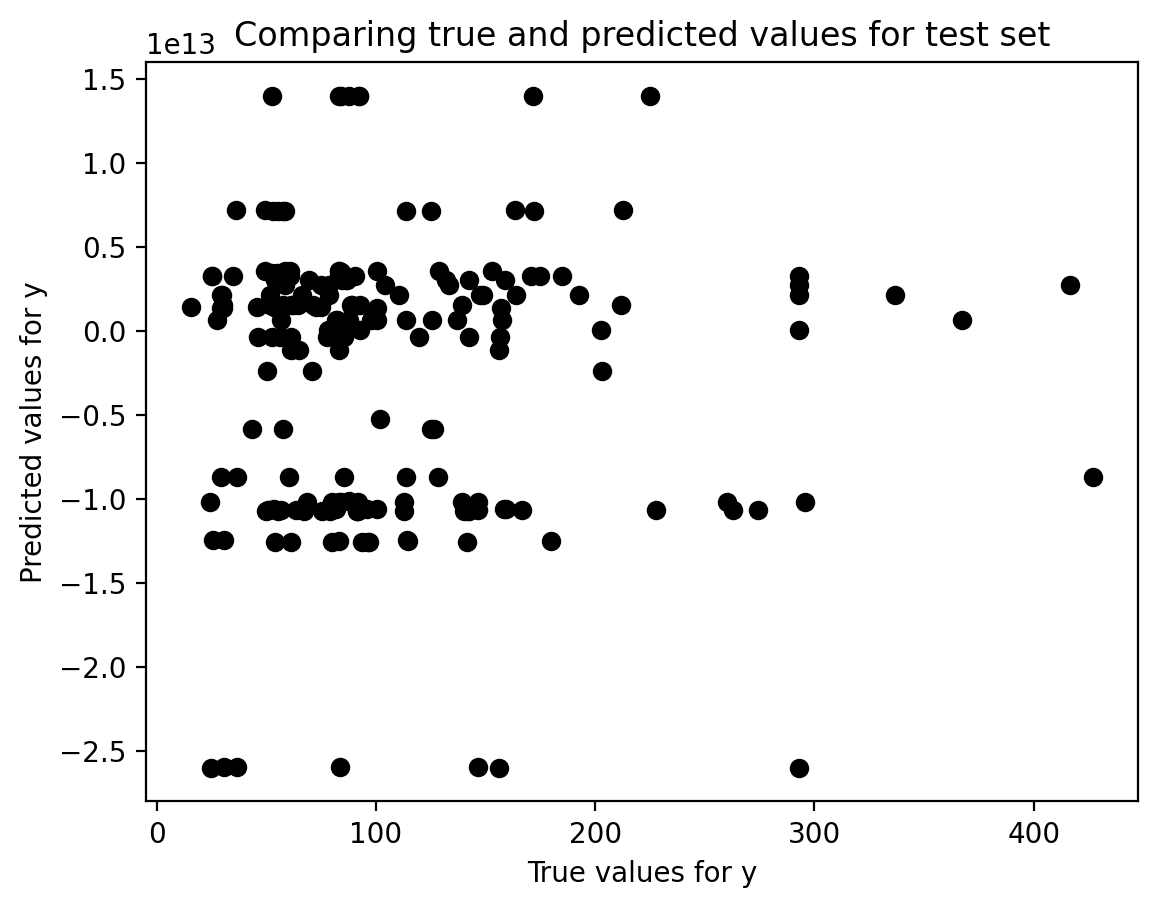

In [66]:
# Comparing true versus predicted values
plt.scatter(y_val, y_test_pred, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_val, y_test_pred)))
print('R-squared = %.4f' % r2_score(y_val, y_test_pred))

Ok för träningsetet, men inte så bra för validering... Kan vi göra det bättre? låt oss testa ridge regression...

In [77]:
ridge = linear_model.Ridge(alpha=0.8)
ridge.fit(X_train, y_train)


Ridge(alpha=0.8)

Let us again test the performance:

train test
Root mean squared error = 18.4707
R-squared = 0.9071
val test
Root mean squared error = 26.0431
R-squared = 0.8690
test test
Root mean squared error = 36.5544
R-squared = 0.7838


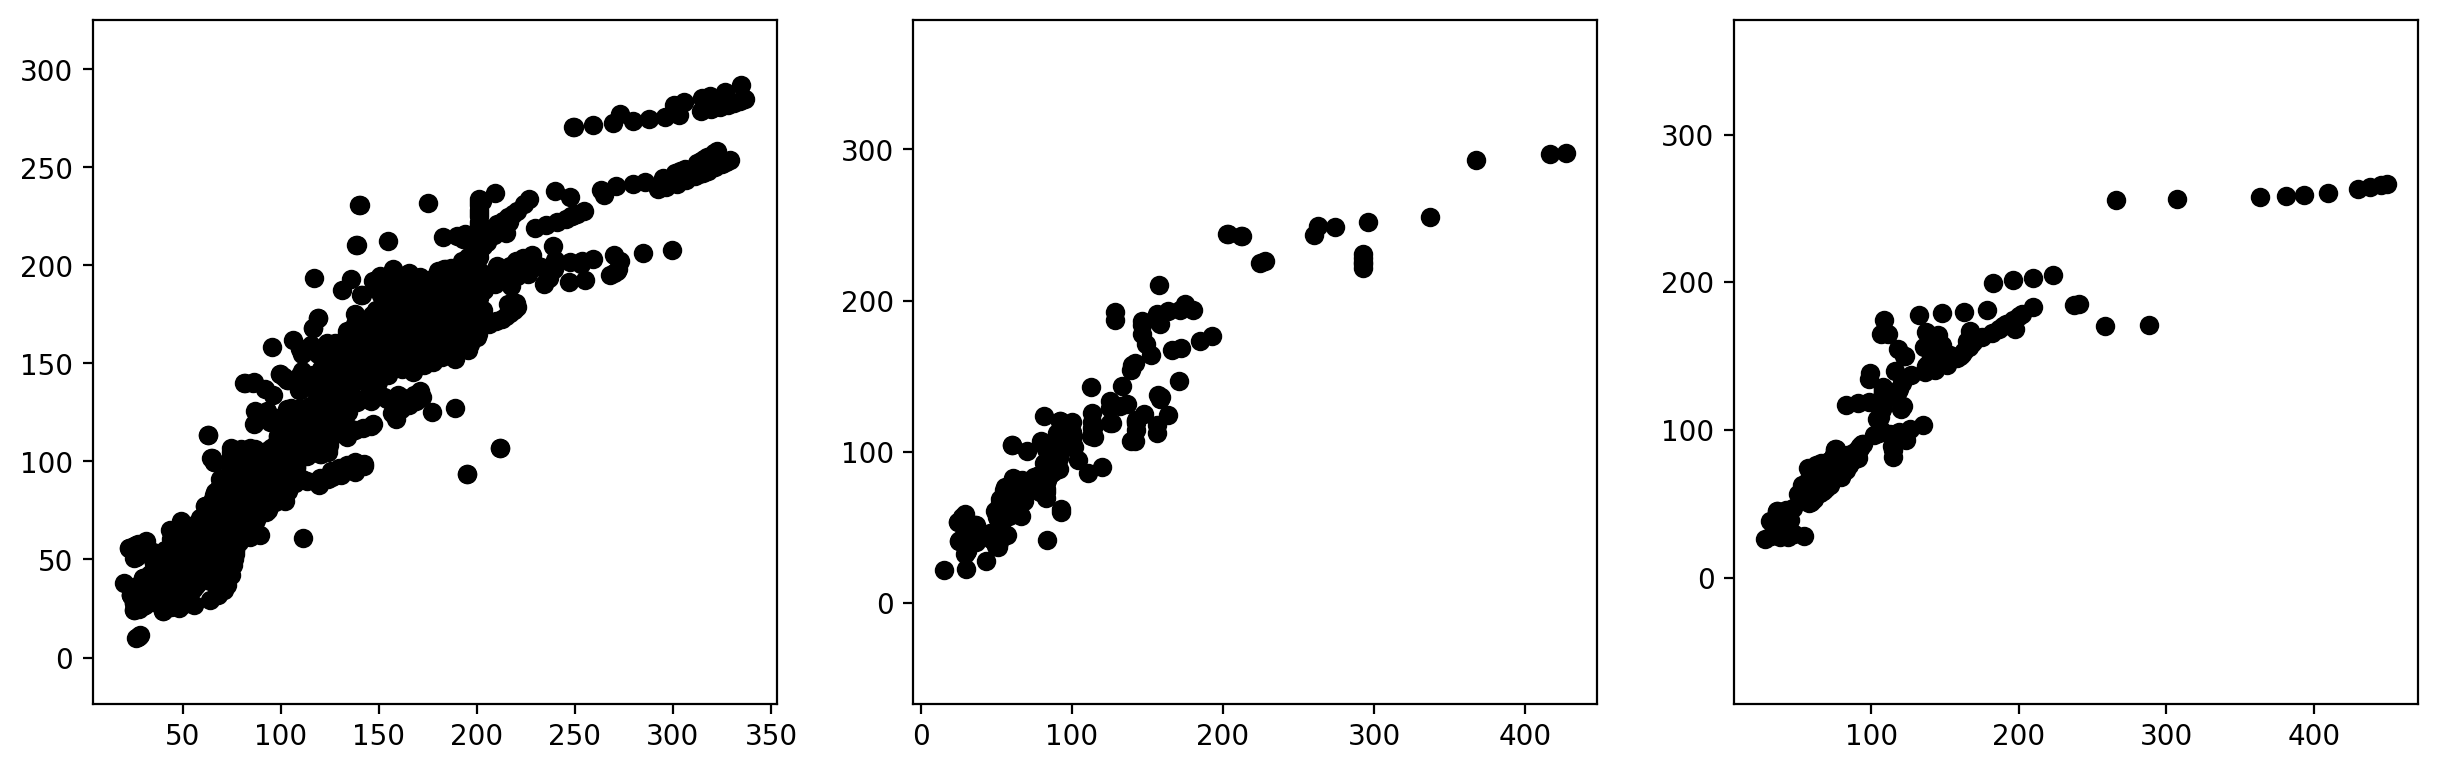

In [106]:
fig, axs = plt.subplots(1,3, figsize=(15,8))

y_train_pred = ridge.predict(X_train)
# Comparing true versus predicted values
axs[0].scatter(y_train, y_train_pred, color='black')
#axs[0].title('Comparing true and predicted values for test set')
#axs[0].xlabel('True values for y')
#axs[0].ylabel('Predicted values for y')

# Model evaluation
print('train test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('R-squared = %.4f' % r2_score(y_train, y_train_pred))


y_val_pred = ridge.predict(X_val)
# Comparing true versus predicted values
axs[1].scatter(y_val, y_val_pred, color='black')
#axs[1].title('Comparing true and predicted values for test set')
#axs[1].xlabel('True values for y')
#axs[1].ylabel('Predicted values for y')

# Model evaluation
print('val test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('R-squared = %.4f' % r2_score(y_val, y_val_pred))


y_test_pred = ridge.predict(X_test)
# Comparing true versus predicted values
axs[2].scatter(y_test, y_test_pred, color='black')
#axs[2].title('Comparing true and predicted values for test set')
#axs[2].xlabel('True values for y')
#axs[2].ylabel('Predicted values for y')

# Model evaluation
print('test test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R-squared = %.4f' % r2_score(y_test, y_test_pred))

for i in range(3):
    axs[i].axis('equal')
    axs[i].set_box_aspect(1)

Much better!!!


However, sk-learn has many options... such as the kernel regression discussed in Lecture 2, can we get better?  


In [112]:
from sklearn.kernel_ridge import KernelRidge
# Kernel ridge regression with RBF
gamma=1
kernel_ridge_reg = KernelRidge(alpha=0.1, kernel='rbf', gamma=gamma)
kernel_ridge_reg.fit(X_train, y_train)


KernelRidge(alpha=0.1, gamma=1, kernel='rbf')

train test
Root mean squared error = 11.0710
R-squared = 0.9666
val test
Root mean squared error = 21.9896
R-squared = 0.9066
test test
Root mean squared error = 28.5498
R-squared = 0.8681


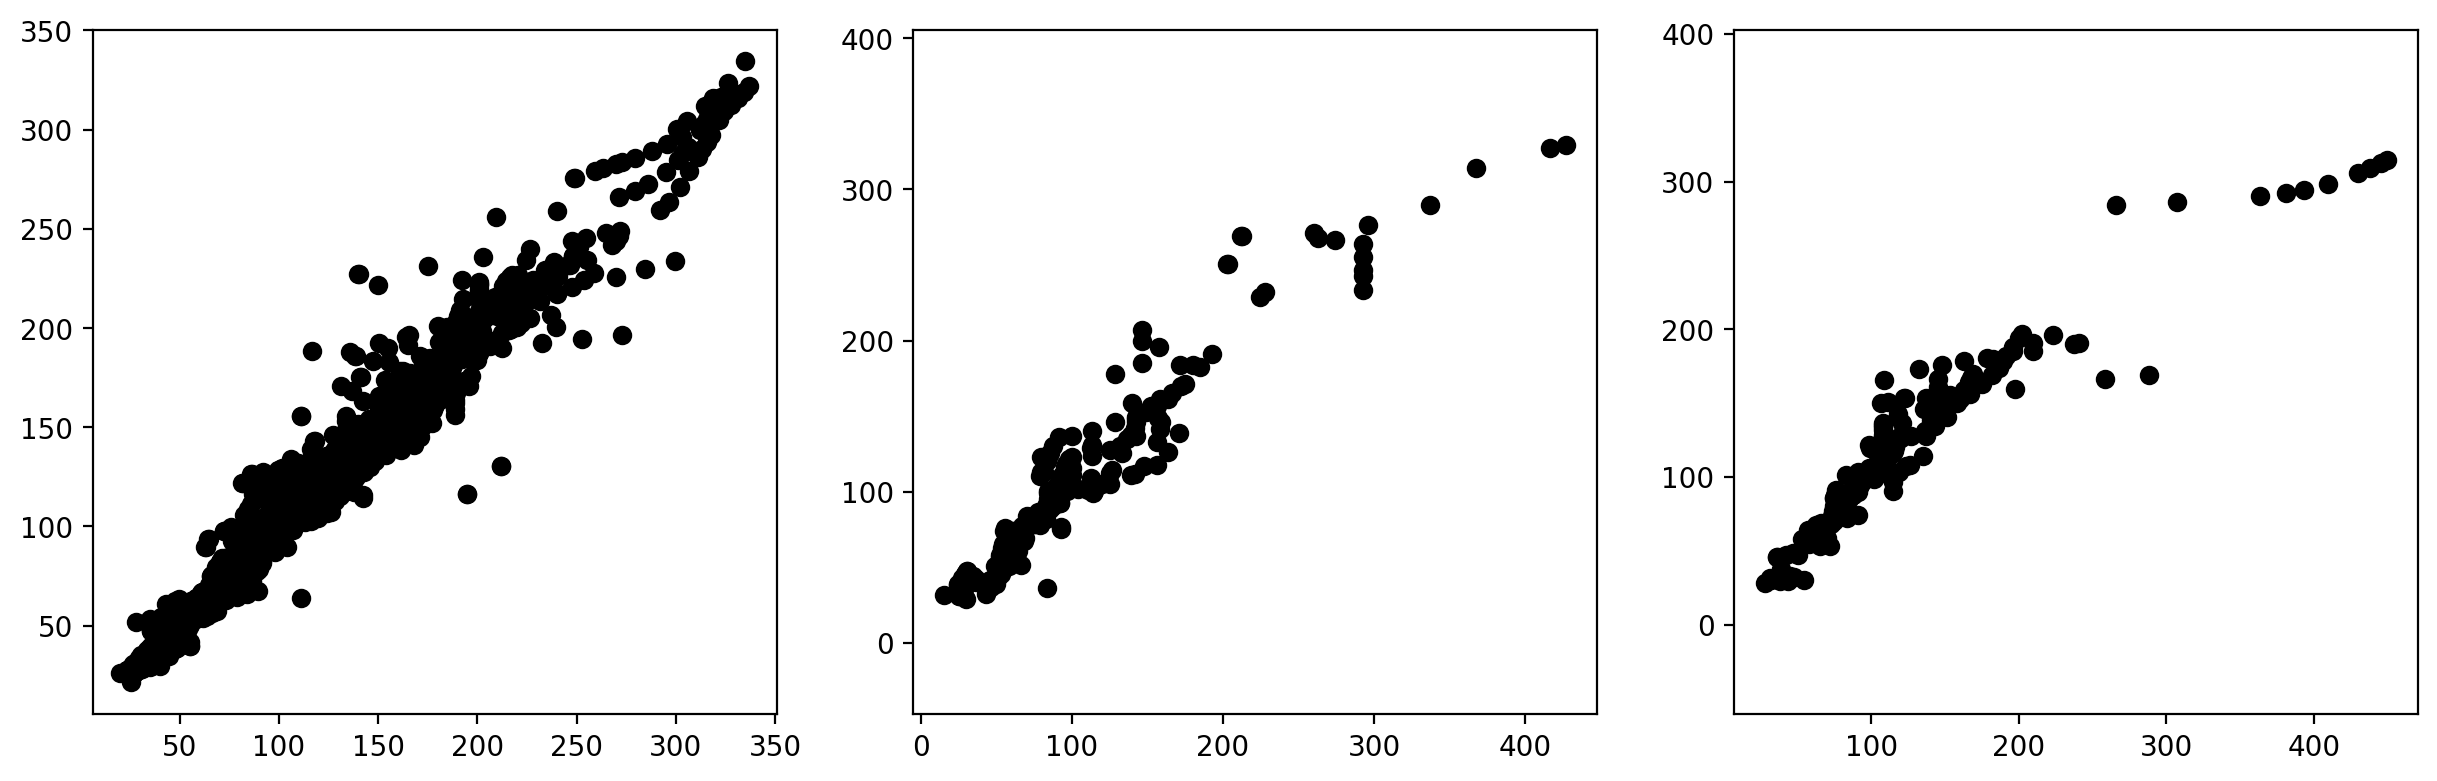

In [113]:
fig, axs = plt.subplots(1,3, figsize=(15,8))

y_train_pred = kernel_ridge_reg .predict(X_train)
# Comparing true versus predicted values
axs[0].scatter(y_train, y_train_pred, color='black')
#axs[0].title('Comparing true and predicted values for test set')
#axs[0].xlabel('True values for y')
#axs[0].ylabel('Predicted values for y')

# Model evaluation
print('train test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_train, y_train_pred)))
print('R-squared = %.4f' % r2_score(y_train, y_train_pred))


y_val_pred = kernel_ridge_reg .predict(X_val)
# Comparing true versus predicted values
axs[1].scatter(y_val, y_val_pred, color='black')
#axs[1].title('Comparing true and predicted values for test set')
#axs[1].xlabel('True values for y')
#axs[1].ylabel('Predicted values for y')

# Model evaluation
print('val test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('R-squared = %.4f' % r2_score(y_val, y_val_pred))


y_test_pred = kernel_ridge_reg .predict(X_test)
# Comparing true versus predicted values
axs[2].scatter(y_test, y_test_pred, color='black')
#axs[2].title('Comparing true and predicted values for test set')
#axs[2].xlabel('True values for y')
#axs[2].ylabel('Predicted values for y')

# Model evaluation
print('test test')
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('R-squared = %.4f' % r2_score(y_test, y_test_pred))

for i in range(3):
    axs[i].axis('equal')
    axs[i].set_box_aspect(1)
